In [1]:
import keras
import tensorflow as tf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
import time
import os
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D
from keras.layers import LeakyReLU, PReLU
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## 1. Obtenção e adequação do _dataset_

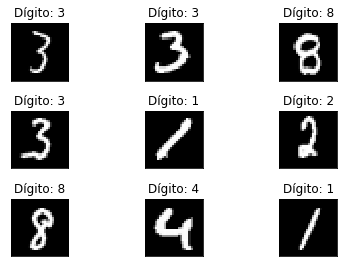

In [2]:
# Obtenção e adequação do dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_dataset = np.concatenate((x_train, x_test))
y_dataset = np.concatenate((y_train, y_test))

# Divisão do dataset entre treinamento e teste 
x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, train_size=0.8, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.75, test_size=0.25)

# Exibição de instâncias do dataset
fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(x_train[i], cmap='gray', interpolation='none')
    plt.title("Dígito: {}".format(y_train[i]))
    plt.xticks([])
    plt.yticks([])
fig

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

y_train = keras.utils.to_categorical(y_train, 10)
y_val = keras.utils.to_categorical(y_val, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# Extensão por '0'
x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
x_val = np.pad(x_val, ((0,0),(2,2),(2,2),(0,0)), 'constant')
x_test = np.pad(x_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

## 2. Configurações iniciais

In [3]:
# Variáveis globais
num_epochs = 30
batch_size = 128
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Criar diretório onde será salvo as imagens
dirName = 'Imagens'
try:
    os.mkdir(dirName)
    print("Os gráficos serão salvos no diretório "+dirName+"/") 
except FileExistsError:
    print("Falha ao criar diretório. O diretório já existe ou não foi possível cria-lo") 

    
# Implementação de um callback para computar o tempo de cada época
class TimingCallback(keras.callbacks.Callback):
    def getTrainTime(self):
        return sum(self.times)
    
    def getAvgTimePerEpoch(self):
        return sum(self.times) / len(self.times)
    
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        
        
# Implementação de uma função para gerar gráfico da acurácia e perda durante treinamento e validação 
plt.style.use('seaborn-white')
matplotlib.rcParams.update({'font.size': 12})
def visualize_history(hist, name):
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    x = range(1, len(acc) + 1)
    
    fig = plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, label='Treinamento')
    plt.plot(x, val_acc, label='Validação')
    plt.xticks(np.arange(2, num_epochs+1, 4))
    plt.ylabel('Acurácia')
    plt.xlabel('Época')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, label='Treinamento')
    plt.plot(x, val_loss, label='Validação')
    plt.xticks(np.arange(2, num_epochs+1, 4))
    plt.ylabel('Perda')
    plt.xlabel('Época')
    plt.legend()
    fig.savefig(dirName+ "/" + name +".png") 

Falha ao criar diretório. O diretório já existe ou não foi possível cria-lo


## 3. LeNet Clássica

In [4]:
# Implementação da LeNet Clássica
model_classic = Sequential()
model_classic.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(32,32,1)))
model_classic.add(AveragePooling2D(pool_size=(2, 2)))
model_classic.add(Conv2D(16, (5, 5), activation='tanh'))
model_classic.add(AveragePooling2D(pool_size=(2, 2)))

model_classic.add(Conv2D(120, (5, 5), activation='tanh'))
model_classic.add(Flatten())
model_classic.add(Dense(84, activation='tanh'))
model_classic.add(Dense(10, activation='softmax'))

model_classic.summary()
model_classic.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_2 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_1 (Flatten)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 84)                10164     
__________


Acurácia no teste: 0.9887
Tempo de execução: 785.7047s
Tempo médio por epóca: 26.1902s


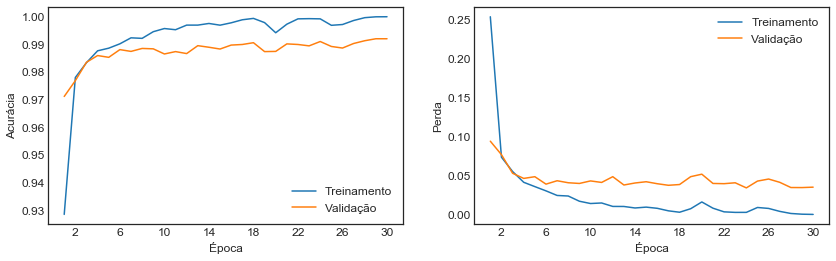

In [5]:
# Treinamento da leNet Clássica
tc_classic = TimingCallback()
history_classic = model_classic.fit(x_train, y_train, epochs=num_epochs, verbose=False, batch_size=batch_size, 
                  validation_data=(x_val, y_val), callbacks=[tc_classic])

loss_classic, accuracy_classic = model_classic.evaluate(x_test, y_test, verbose=False)

print("")
print("Acurácia no teste: {:.4f}".format(accuracy_classic))
print("Tempo de execução: {:.4f}s".format(tc_classic.getTrainTime()))
print("Tempo médio por epóca: {:.4f}s".format(tc_classic.getAvgTimePerEpoch()))

visualize_history(history_classic, 'LeNet Clássica')

## 4. Variações da LeNet Clássica
### 4.1 LeNet com alteração no número de camadas

In [6]:
# Alteração da LeNet Clássica com adição de mais uma camada
model_layer = Sequential()
model_layer.add(Conv2D(6, kernel_size=(3,3), activation='tanh', input_shape=(32,32,1), padding='same'))
model_layer.add(AveragePooling2D(pool_size=(2,2)))
model_layer.add(Conv2D(6, kernel_size=(3,3), activation='tanh'))
model_layer.add(AveragePooling2D(pool_size=(2,2)))
model_layer.add(Conv2D(16, kernel_size=(3,3), activation='tanh'))

model_layer.add(Conv2D(120, kernel_size=(5,5), activation='tanh'))
model_layer.add(Flatten())
model_layer.add(Dense(84, activation='tanh'))
model_layer.add(Dense(10, activation='softmax'))

model_layer.summary()
model_layer.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 6)         60        
_________________________________________________________________
average_pooling2d_3 (Average (None, 16, 16, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 6)         330       
_________________________________________________________________
average_pooling2d_4 (Average (None, 7, 7, 6)           0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 5, 5, 16)          880       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_2 (Flatten)          (None, 120)               0         
__________


Acurácia no teste: 0.9881
Tempo de execução: 733.1980s
Tempo médio por epóca: 24.4399s


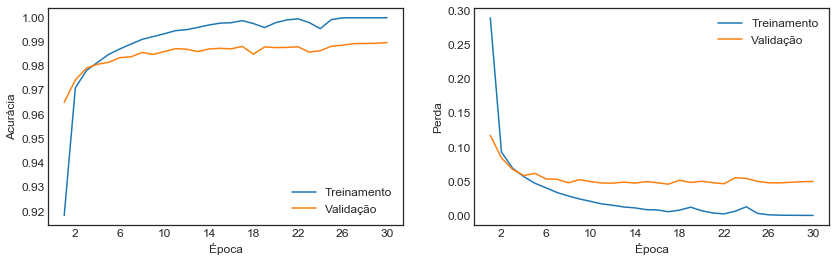

In [7]:
tc_layer = TimingCallback()
history_layer = model_layer.fit(x_train, y_train, epochs=num_epochs, verbose=False, batch_size=batch_size, 
                  validation_data=(x_val, y_val), callbacks=[tc_layer])

loss_layer, accuracy_layer = model_layer.evaluate(x_test, y_test, verbose=False)

print("")
print("Acurácia no teste: {:.4f}".format(accuracy_layer))
print("Tempo de execução: {:.4f}s".format(tc_layer.getTrainTime()))
print("Tempo médio por epóca: {:.4f}s".format(tc_layer.getAvgTimePerEpoch()))

visualize_history(history_layer, 'LeNet com alteração nas camadas')

### 4.2 LeNet com alteração no número de filtros por camada

In [8]:
# Duplicação do número de filtros por camada
model_nfilter = Sequential()
model_nfilter.add(Conv2D(12, kernel_size=(5, 5), activation='tanh', input_shape=(32,32,1)))
model_nfilter.add(AveragePooling2D(pool_size=(2, 2)))
model_nfilter.add(Conv2D(32, (5, 5), activation='tanh'))
model_nfilter.add(AveragePooling2D(pool_size=(2, 2)))

model_nfilter.add(Conv2D(240, (5, 5), activation='tanh'))
model_nfilter.add(Flatten())
model_nfilter.add(Dense(84, activation='tanh'))
model_nfilter.add(Dense(10, activation='softmax'))

model_nfilter.summary()
model_nfilter.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 12)        312       
_________________________________________________________________
average_pooling2d_5 (Average (None, 14, 14, 12)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 32)        9632      
_________________________________________________________________
average_pooling2d_6 (Average (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 1, 240)         192240    
_________________________________________________________________
flatten_3 (Flatten)          (None, 240)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 84)                20244     
__________


Acurácia no teste: 0.9900
Tempo de execução: 1575.1950s
Tempo médio por epóca: 52.5065s


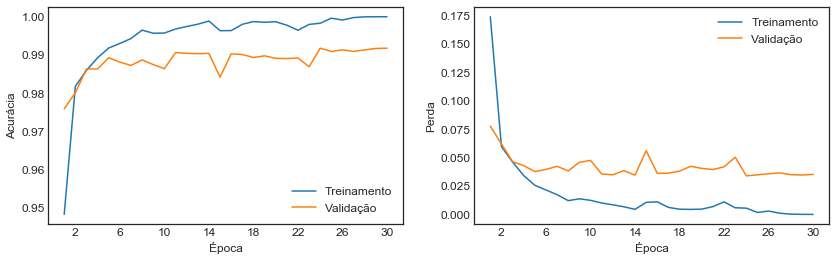

In [9]:
tc_nfilter = TimingCallback()
history_nfilter = model_nfilter.fit(x_train, y_train, epochs=num_epochs, verbose=False, batch_size=batch_size, 
                  validation_data=(x_val, y_val), callbacks=[tc_nfilter])

loss_nfilter, accuracy_nfilter = model_nfilter.evaluate(x_test, y_test, verbose=False)

print("")
print("Acurácia no teste: {:.4f}".format(accuracy_nfilter))
print("Tempo de execução: {:.4f}s".format(tc_nfilter.getTrainTime()))
print("Tempo médio por epóca: {:.4f}s".format(tc_nfilter.getAvgTimePerEpoch()))

visualize_history(history_nfilter, 'LeNet com alteração no número de filtros')

### 4.3 LeNet com alteração nas dimensões dos filtros

In [10]:
model_cfilter = Sequential()
model_cfilter.add(Conv2D(6, kernel_size=(9,9), activation='tanh', input_shape=(32,32,1)))
model_cfilter.add(AveragePooling2D(pool_size=(2,2)))
model_cfilter.add(Conv2D(16, kernel_size=(3,3), activation='tanh'))
model_cfilter.add(AveragePooling2D(pool_size=(2,2)))

model_cfilter.add(Conv2D(120, (5, 5), activation='tanh'))
model_cfilter.add(Flatten())
model_cfilter.add(Dense(84, activation='tanh'))
model_cfilter.add(Dense(10, activation='softmax'))

model_cfilter.summary()
model_cfilter.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 24, 24, 6)         492       
_________________________________________________________________
average_pooling2d_7 (Average (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 10, 10, 16)        880       
_________________________________________________________________
average_pooling2d_8 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_4 (Flatten)          (None, 120)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 84)                10164     
__________


Acurácia no teste: 0.9847
Tempo de execução: 875.4688s
Tempo médio por epóca: 29.1823s


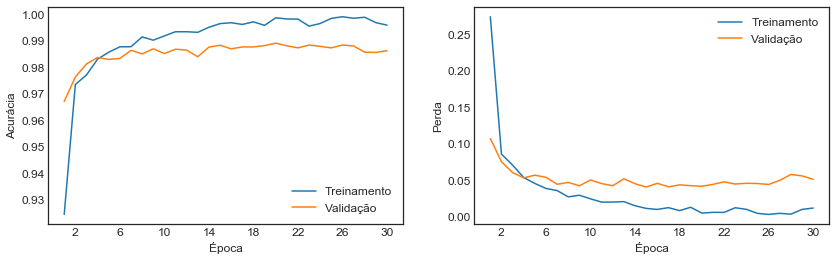

In [11]:
tc_cfilter = TimingCallback()
history_cfilter = model_cfilter.fit(x_train, y_train, epochs=num_epochs, verbose=False, batch_size=batch_size, 
                  validation_data=(x_val, y_val), callbacks=[tc_cfilter])

loss_cfilter, accuracy_cfilter = model_cfilter.evaluate(x_test, y_test, verbose=False)

print("")
print("Acurácia no teste: {:.4f}".format(accuracy_cfilter))
print("Tempo de execução: {:.4f}s".format(tc_cfilter.getTrainTime()))
print("Tempo médio por epóca: {:.4f}s".format(tc_cfilter.getAvgTimePerEpoch()))

visualize_history(history_cfilter, 'LeNet com alteração na dimensão dos filtros')

### 4.4 LeNet com redução da Taxa de Aprendizagem

In [12]:
model_lrl = Sequential()
model_lrl.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(32,32,1)))
model_lrl.add(AveragePooling2D(pool_size=(2, 2)))
model_lrl.add(Conv2D(16, (5, 5), activation='tanh'))
model_lrl.add(AveragePooling2D(pool_size=(2, 2)))

model_lrl.add(Conv2D(120, (5, 5), activation='tanh'))
model_lrl.add(Flatten())
model_lrl.add(Dense(84, activation='tanh'))
model_lrl.add(Dense(10, activation='softmax'))

model_lrl.summary()

adam_lrl = Adam(lr=0.00001) 
model_lrl.compile(loss=keras.losses.categorical_crossentropy, optimizer=adam_lrl, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_9 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_10 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_5 (Flatten)          (None, 120)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 84)                10164     
__________


Acurácia no teste: 0.9572
Tempo de execução: 788.0863s
Tempo médio por epóca: 26.2695s


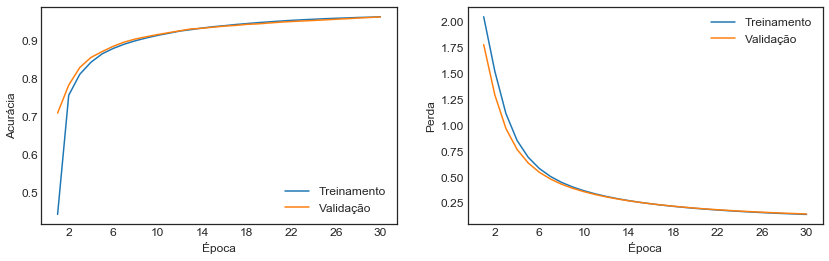

In [13]:
tc_lrl = TimingCallback()
history_lrl = model_lrl.fit(x_train, y_train, epochs=num_epochs, verbose=False, batch_size=batch_size, 
                  validation_data=(x_val, y_val), callbacks=[tc_lrl])

loss_lrl, accuracy_lrl = model_lrl.evaluate(x_test, y_test, verbose=False)

print("")
print("Acurácia no teste: {:.4f}".format(accuracy_lrl))
print("Tempo de execução: {:.4f}s".format(tc_lrl.getTrainTime()))
print("Tempo médio por epóca: {:.4f}s".format(tc_lrl.getAvgTimePerEpoch()))

visualize_history(history_lrl, 'LeNet com redução da TA')

### 4.5 LeNet com aumento da Taxa de Aprendizagem

In [14]:
model_lrh = Sequential()
model_lrh.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(32,32,1)))
model_lrh.add(AveragePooling2D(pool_size=(2, 2)))
model_lrh.add(Conv2D(16, (5, 5), activation='tanh'))
model_lrh.add(AveragePooling2D(pool_size=(2, 2)))

model_lrh.add(Conv2D(120, (5, 5), activation='tanh'))
model_lrh.add(Flatten())
model_lrh.add(Dense(84, activation='tanh'))
model_lrh.add(Dense(10, activation='softmax'))

model_lrh.summary()

adam_lrh = Adam(lr=0.01) 
model_lrh.compile(loss=keras.losses.categorical_crossentropy, optimizer=adam_lrh, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_11 (Averag (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_12 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_6 (Flatten)          (None, 120)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 84)                10164     
__________


Acurácia no teste: 0.9622
Tempo de execução: 789.5353s
Tempo médio por epóca: 26.3178s


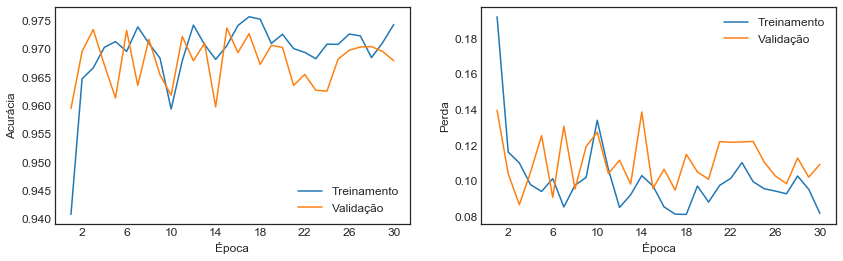

In [15]:
tc_lrh = TimingCallback()
history_lrh = model_lrh.fit(x_train, y_train, epochs=num_epochs, verbose=False, batch_size=batch_size, 
                  validation_data=(x_val, y_val), callbacks=[tc_lrh])

loss_lrh, accuracy_lrh = model_lrh.evaluate(x_test, y_test, verbose=False)

print("")
print("Acurácia no teste: {:.4f}".format(accuracy_lrh))
print("Tempo de execução: {:.4f}s".format(tc_lrh.getTrainTime()))
print("Tempo médio por epóca: {:.4f}s".format(tc_lrh.getAvgTimePerEpoch()))

visualize_history(history_lrh, 'LeNet com aumento da TA')

### 4.6 LeNet com ReLU

In [16]:
# Alteração na função de ativação de cada camada
model_relu = Sequential()
model_relu.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(32,32,1)))
model_relu.add(AveragePooling2D(pool_size=(2, 2)))
model_relu.add(Conv2D(16, (5, 5), activation='relu'))
model_relu.add(AveragePooling2D(pool_size=(2, 2)))

model_relu.add(Conv2D(120, (5, 5), activation='relu'))
model_relu.add(Flatten())
model_relu.add(Dense(84, activation='relu'))
model_relu.add(Dense(10, activation='softmax'))

model_relu.summary()
model_relu.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_13 (Averag (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_14 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_7 (Flatten)          (None, 120)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 84)                10164     
__________


Acurácia no teste: 0.9851
Tempo de execução: 705.2508s
Tempo médio por epóca: 23.5084s


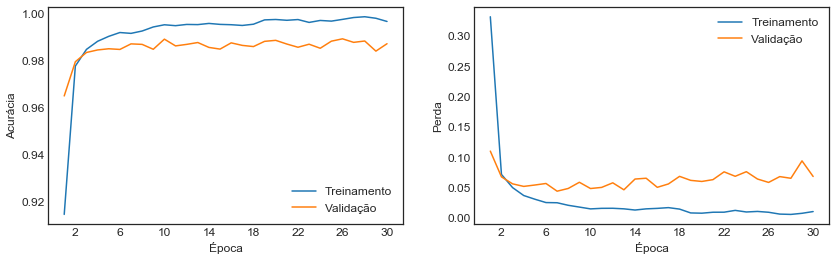

In [17]:
tc_relu = TimingCallback()
history_relu = model_relu.fit(x_train, y_train, epochs=num_epochs, verbose=False, batch_size=batch_size, 
                  validation_data=(x_val, y_val), callbacks=[tc_relu])

loss_relu, accuracy_relu = model_relu.evaluate(x_test, y_test, verbose=False)

print("")
print("Acurácia no teste: {:.4f}".format(accuracy_relu))
print("Tempo de execução: {:.4f}s".format(tc_relu.getTrainTime()))
print("Tempo médio por epóca: {:.4f}s".format(tc_relu.getAvgTimePerEpoch()))

visualize_history(history_relu, 'LeNet com ReLU')

### 4.7 LeNet com Leaky ReLu

In [18]:
# Alteração na função de ativação de cada camada
model_leaky = Sequential()

model_leaky.add(Conv2D(6, kernel_size=(5, 5), input_shape=(32,32,1)))
model_leaky.add(LeakyReLU())

model_leaky.add(AveragePooling2D(pool_size=(2, 2)))

model_leaky.add(Conv2D(16, (5, 5)))
model_leaky.add(LeakyReLU())

model_leaky.add(AveragePooling2D(pool_size=(2, 2)))

model_leaky.add(Conv2D(120, (5, 5)))
model_leaky.add(LeakyReLU())

model_leaky.add(Flatten())

model_leaky.add(Dense(84))
model_leaky.add(LeakyReLU())

model_leaky.add(Dense(10, activation='softmax'))

model_leaky.summary()
model_leaky.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 6)         0         
_________________________________________________________________
average_pooling2d_15 (Averag (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 10, 10, 16)        0         
_________________________________________________________________
average_pooling2d_16 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 1, 1, 120)         48120     
__________


Acurácia no teste: 0.9839
Tempo de execução: 856.3187s
Tempo médio por epóca: 28.5440s


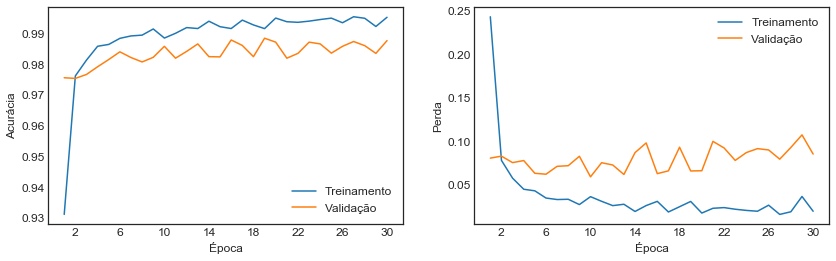

In [19]:
tc_leaky = TimingCallback()
history_leaky = model_leaky.fit(x_train, y_train, epochs=num_epochs, verbose=False, batch_size=batch_size, 
                  validation_data=(x_val, y_val), callbacks=[tc_leaky])

loss_leaky, accuracy_leaky = model_leaky.evaluate(x_test, y_test, verbose=False)

print("")
print("Acurácia no teste: {:.4f}".format(accuracy_leaky))
print("Tempo de execução: {:.4f}s".format(tc_leaky.getTrainTime()))
print("Tempo médio por epóca: {:.4f}s".format(tc_leaky.getAvgTimePerEpoch()))

visualize_history(history_leaky, 'LeNet com LeakyReLU')

### 4.8 LeNet com PReLU

In [20]:
model_prelu = Sequential()

model_prelu.add(Conv2D(6, kernel_size=(5, 5), input_shape=(32,32,1)))
model_prelu.add(PReLU())

model_prelu.add(AveragePooling2D(pool_size=(2, 2)))

model_prelu.add(Conv2D(16, (5, 5)))
model_prelu.add(PReLU())

model_prelu.add(AveragePooling2D(pool_size=(2, 2)))

model_prelu.add(Conv2D(120, (5, 5)))
model_prelu.add(PReLU())

model_prelu.add(Flatten())

model_prelu.add(Dense(84))
model_prelu.add(PReLU())

model_prelu.add(Dense(10, activation='softmax'))

model_prelu.summary()
model_prelu.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 28, 28, 6)         4704      
_________________________________________________________________
average_pooling2d_17 (Averag (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 10, 10, 16)        1600      
_________________________________________________________________
average_pooling2d_18 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 1, 1, 120)         48120     
__________


Acurácia no teste: 0.9860
Tempo de execução: 916.0443s
Tempo médio por epóca: 30.5348s


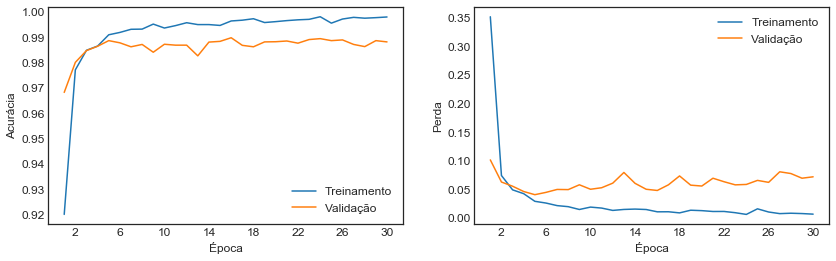

In [21]:
tc_prelu = TimingCallback()
history_prelu = model_prelu.fit(x_train, y_train, epochs=num_epochs, verbose=False, batch_size=batch_size, 
                  validation_data=(x_val, y_val), callbacks=[tc_prelu])

loss_prelu, accuracy_prelu = model_prelu.evaluate(x_test, y_test, verbose=False)

print("")
print("Acurácia no teste: {:.4f}".format(accuracy_prelu))
print("Tempo de execução: {:.4f}s".format(tc_prelu.getTrainTime()))
print("Tempo médio por epóca: {:.4f}s".format(tc_prelu.getAvgTimePerEpoch()))

visualize_history(history_prelu, 'LeNet com PReLU')

### 4.9 LeNet com redução do Minibatch

In [22]:
model_rmb = Sequential()
model_rmb.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(32,32,1)))
model_rmb.add(AveragePooling2D(pool_size=(2, 2)))
model_rmb.add(Conv2D(16, (5, 5), activation='tanh'))
model_rmb.add(AveragePooling2D(pool_size=(2, 2)))

model_rmb.add(Conv2D(120, (5, 5), activation='tanh'))
model_rmb.add(Flatten())
model_rmb.add(Dense(84, activation='tanh'))
model_rmb.add(Dense(10, activation='softmax'))

model_rmb.summary()
model_rmb.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_19 (Averag (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_20 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_10 (Flatten)         (None, 120)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 84)                10164     
__________


Acurácia no teste: 0.9854
Tempo de execução: 929.6594s
Tempo médio por epóca: 30.9886s


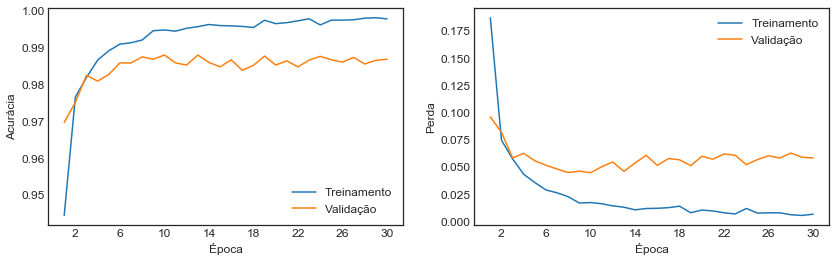

In [23]:
tc_rmb = TimingCallback()
history_rmb = model_rmb.fit(x_train, y_train, epochs=num_epochs, verbose=False, batch_size=32, 
                  validation_data=(x_val, y_val), callbacks=[tc_rmb])

loss_rmb, accuracy_rmb = model_rmb.evaluate(x_test, y_test, verbose=False)

print("")
print("Acurácia no teste: {:.4f}".format(accuracy_rmb))
print("Tempo de execução: {:.4f}s".format(tc_rmb.getTrainTime()))
print("Tempo médio por epóca: {:.4f}s".format(tc_rmb.getAvgTimePerEpoch()))

visualize_history(history_rmb, 'LeNet com redução do Minibatch')

### 4.10 LeNet com aumento do Minibatch

In [24]:
model_imb = Sequential()
model_imb.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(32,32,1)))
model_imb.add(AveragePooling2D(pool_size=(2, 2)))
model_imb.add(Conv2D(16, (5, 5), activation='tanh'))
model_imb.add(AveragePooling2D(pool_size=(2, 2)))

model_imb.add(Conv2D(120, (5, 5), activation='tanh'))
model_imb.add(Flatten())
model_imb.add(Dense(84, activation='tanh'))
model_imb.add(Dense(10, activation='softmax'))

model_imb.summary()
model_imb.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_21 (Averag (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_22 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_11 (Flatten)         (None, 120)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 84)                10164     
__________


Acurácia no teste: 0.9879
Tempo de execução: 754.9681s
Tempo médio por epóca: 25.1656s


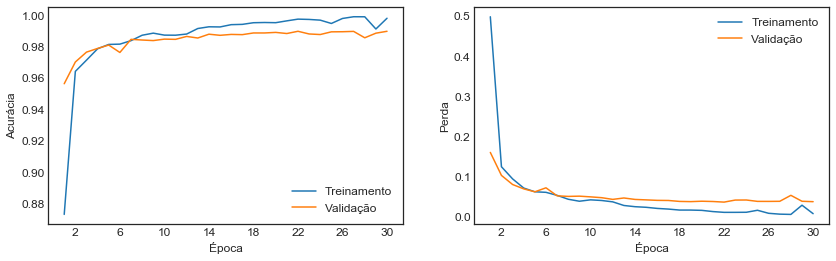

In [25]:
tc_imb = TimingCallback()
history_imb = model_imb.fit(x_train, y_train, epochs=num_epochs, verbose=False, batch_size=512, 
                  validation_data=(x_val, y_val), callbacks=[tc_imb])

loss_imb, accuracy_imb = model_imb.evaluate(x_test, y_test, verbose=False)

print("")
print("Acurácia no teste: {:.4f}".format(accuracy_imb))
print("Tempo de execução: {:.4f}s".format(tc_imb.getTrainTime()))
print("Tempo médio por epóca: {:.4f}s".format(tc_imb.getAvgTimePerEpoch()))

visualize_history(history_imb, 'LeNet com aumento do Minibatch')

### 4.11 LeNet com SGD

In [26]:
model_sgd = Sequential()
model_sgd.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(32,32,1)))
model_sgd.add(AveragePooling2D(pool_size=(2, 2)))
model_sgd.add(Conv2D(16, (5, 5), activation='tanh'))
model_sgd.add(AveragePooling2D(pool_size=(2, 2)))

model_sgd.add(Conv2D(120, (5, 5), activation='tanh'))
model_sgd.add(Flatten())
model_sgd.add(Dense(84, activation='tanh'))
model_sgd.add(Dense(10, activation='softmax'))

model_sgd.summary()
model_sgd.compile(loss=keras.losses.categorical_crossentropy, optimizer=SGD(), metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_23 (Averag (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_24 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_12 (Flatten)         (None, 120)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 84)                10164     
__________


Acurácia no teste: 0.9762
Tempo de execução: 785.7684s
Tempo médio por epóca: 26.1923s


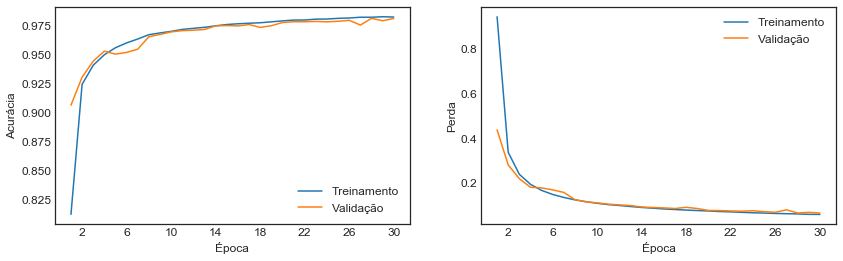

In [27]:
tc_sgd = TimingCallback()
history_sgd = model_sgd.fit(x_train, y_train, epochs=num_epochs, verbose=False, batch_size=batch_size, 
                  validation_data=(x_val, y_val), callbacks=[tc_sgd])

loss_sgd, accuracy_sgd = model_sgd.evaluate(x_test, y_test, verbose=False)

print("")
print("Acurácia no teste: {:.4f}".format(accuracy_sgd))
print("Tempo de execução: {:.4f}s".format(tc_sgd.getTrainTime()))
print("Tempo médio por epóca: {:.4f}s".format(tc_sgd.getAvgTimePerEpoch()))

visualize_history(history_sgd, 'LeNet com SGD')

### 4.12 LeNet com SGD + Momentum

In [28]:
model_sgdm = Sequential()
model_sgdm.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(32,32,1)))
model_sgdm.add(AveragePooling2D(pool_size=(2, 2)))
model_sgdm.add(Conv2D(16, (5, 5), activation='tanh'))
model_sgdm.add(AveragePooling2D(pool_size=(2, 2)))

model_sgdm.add(Conv2D(120, (5, 5), activation='tanh'))
model_sgdm.add(Flatten())
model_sgdm.add(Dense(84, activation='tanh'))
model_sgdm.add(Dense(10, activation='softmax'))

model_sgdm.summary()
model_sgdm.compile(loss=keras.losses.categorical_crossentropy, optimizer=SGD(momentum=0.9), metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_25 (Averag (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_26 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_13 (Flatten)         (None, 120)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 84)                10164     
__________


Acurácia no teste: 0.9881
Tempo de execução: 785.2569s
Tempo médio por epóca: 26.1752s


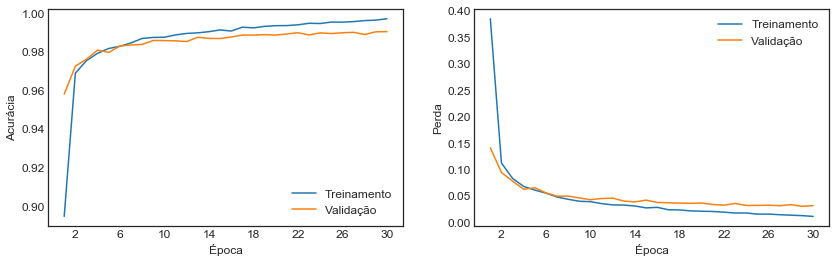

In [29]:
tc_sgdm = TimingCallback()
history_sgdm = model_sgdm.fit(x_train, y_train, epochs=num_epochs, verbose=False, batch_size=batch_size, 
                  validation_data=(x_val, y_val), callbacks=[tc_sgdm])

loss_sgdm, accuracy_sgdm = model_sgdm.evaluate(x_test, y_test, verbose=False)

print("")
print("Acurácia no teste: {:.4f}".format(accuracy_sgdm))
print("Tempo de execução: {:.4f}s".format(tc_sgdm.getTrainTime()))
print("Tempo médio por epóca: {:.4f}s".format(tc_sgdm.getAvgTimePerEpoch()))

visualize_history(history_sgdm, 'LeNet com SGD+Momentum')

### 4.13 LeNet com Data Augmentation (Rotação, translação, zoom e shear)

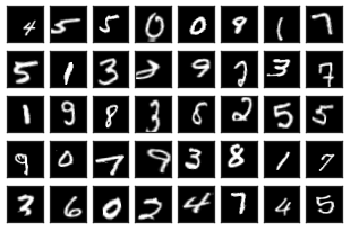

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_27 (Averag (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_28 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_14 (Flatten)         (None, 120)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 84)                10164     
__________

In [30]:
# https://github.com/franneck94/MNIST-Data-Augmentation/blob/master/mnist.py
augment_size = 84000

ig_rtzs = ImageDataGenerator(rotation_range=10, width_shift_range=0.10, height_shift_range=0.10,
            zoom_range=0.25, horizontal_flip=False, shear_range=0.2, vertical_flip=False)
ig_rtzs.fit(x_train, augment=True)

randidx = np.random.randint(x_train.shape[0], size=augment_size)
x_aug_rtzs = x_train[randidx].copy()
y_aug_rtzs = y_train[randidx].copy()
x_aug_rtzs = ig_rtzs.flow(x_aug_rtzs, np.zeros(augment_size), batch_size=augment_size, shuffle=False).next()[0]

x_train_rtzs = np.concatenate((x_train, x_aug_rtzs))
y_train_rtzs = np.concatenate((y_train, y_aug_rtzs))

fig_da = plt.figure()
for X_batch, y_batch in ig_rtzs.flow(x_train_rtzs, y_train_rtzs, batch_size=40):
    for i in range(0, 40):
        plt.subplot(5,8,i+1)
        plt.imshow(X_batch[i].reshape(32, 32), cmap=plt.get_cmap('gray'))
        plt.xticks([])
        plt.yticks([])
    plt.show()
    break

fig_da.savefig(dirName + "\Exemplos do DA (RTZ).png")

# Implementação da LeNet Clássica
model_rtzs = Sequential()
model_rtzs.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(32,32,1)))
model_rtzs.add(AveragePooling2D(pool_size=(2, 2)))
model_rtzs.add(Conv2D(16, (5, 5), activation='tanh'))
model_rtzs.add(AveragePooling2D(pool_size=(2, 2)))

model_rtzs.add(Conv2D(120, (5, 5), activation='tanh'))
model_rtzs.add(Flatten())
model_rtzs.add(Dense(84, activation='tanh'))
model_rtzs.add(Dense(10, activation='softmax'))

model_rtzs.summary()
model_rtzs.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])


Acurácia no teste: 0.9886
Tempo de execução: 2236.7544s
Tempo médio por epóca: 74.5585s


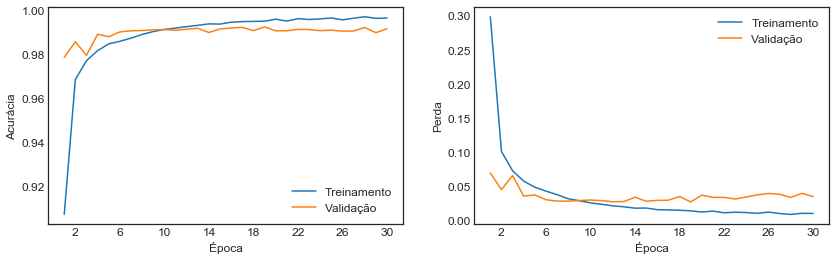

In [31]:
tc_rtzs = TimingCallback()
history_rtzs = model_rtzs.fit(x_train_rtzs, y_train_rtzs, epochs=num_epochs, verbose=False, batch_size=batch_size, 
                  validation_data=(x_val, y_val), callbacks=[tc_rtzs])

loss_rtzs, accuracy_rtzs = model_rtzs.evaluate(x_test, y_test, verbose=False)

print("")
print("Acurácia no teste: {:.4f}".format(accuracy_rtzs))
print("Tempo de execução: {:.4f}s".format(tc_rtzs.getTrainTime()))
print("Tempo médio por epóca: {:.4f}s".format(tc_rtzs.getAvgTimePerEpoch()))

visualize_history(history_rtzs, 'LeNet com Data Augmentation')

### 4.14 LeNet com MaxPooling

In [32]:
model_max = Sequential()
model_max.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(32,32,1)))
model_max.add(MaxPooling2D(pool_size=(2, 2)))
model_max.add(Conv2D(16, (5, 5), activation='tanh'))
model_max.add(MaxPooling2D(pool_size=(2, 2)))

model_max.add(Conv2D(120, (5, 5), activation='tanh'))
model_max.add(Flatten())
model_max.add(Dense(84, activation='tanh'))
model_max.add(Dense(10, activation='softmax'))

model_max.summary()
model_max.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_15 (Flatten)         (None, 120)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 84)                10164     
__________


Acurácia no teste: 0.9832
Tempo de execução: 823.4225s
Tempo médio por epóca: 27.4474s


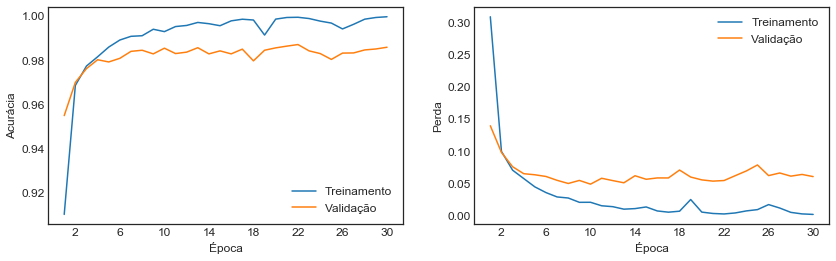

In [33]:
tc_max = TimingCallback()
history_max = model_max.fit(x_train, y_train, epochs=num_epochs, verbose=False, batch_size=batch_size, 
                  validation_data=(x_val, y_val), callbacks=[tc_max])

loss_max, accuracy_max = model_max.evaluate(x_test, y_test, verbose=False)

print("")
print("Acurácia no teste: {:.4f}".format(accuracy_max))
print("Tempo de execução: {:.4f}s".format(tc_max.getTrainTime()))
print("Tempo médio por epóca: {:.4f}s".format(tc_max.getAvgTimePerEpoch()))

visualize_history(history_max, 'LeNet com MaxPooling')

### 4.15 LeNet com Xavier

In [34]:
model_xvr = Sequential()
model_xvr.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(32,32,1), 
             kernel_initializer='glorot_uniform'))
model_xvr.add(AveragePooling2D(pool_size=(2, 2)))
model_xvr.add(Conv2D(16, (5, 5), activation='tanh', kernel_initializer='glorot_normal'))
model_xvr.add(AveragePooling2D(pool_size=(2, 2)))

model_xvr.add(Conv2D(120, (5, 5), activation='tanh', kernel_initializer='glorot_normal'))
model_xvr.add(Flatten())
model_xvr.add(Dense(84, activation='tanh', kernel_initializer='glorot_normal'))
model_xvr.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

model_xvr.summary()
model_xvr.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_29 (Averag (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_30 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_16 (Flatten)         (None, 120)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 84)                10164     
__________


Acurácia no teste: 0.9859
Tempo de execução: 801.1688s
Tempo médio por epóca: 26.7056s


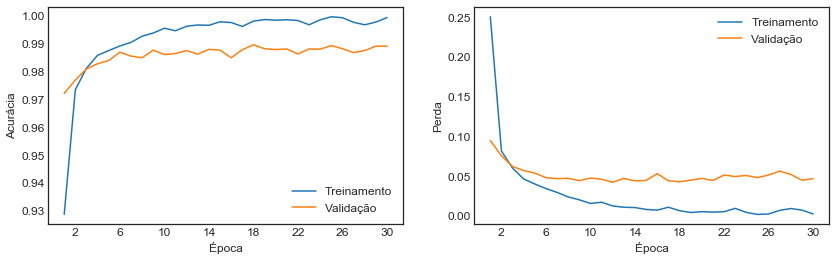

In [35]:
tc_xvr = TimingCallback()
history_xvr = model_xvr.fit(x_train, y_train, epochs=num_epochs, verbose=False, batch_size=batch_size, 
                  validation_data=(x_val, y_val), callbacks=[tc_xvr])

loss_xvr, accuracy_xvr = model_xvr.evaluate(x_test, y_test, verbose=False)

print("")
print("Acurácia no teste: {:.4f}".format(accuracy_xvr))
print("Tempo de execução: {:.4f}s".format(tc_xvr.getTrainTime()))
print("Tempo médio por epóca: {:.4f}s".format(tc_xvr.getAvgTimePerEpoch()))

visualize_history(history_xvr, 'LeNet com Xavier')

### 4.16 LeNet com He

In [36]:
model_he = Sequential()
model_he.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(32,32,1), 
             kernel_initializer='he_normal'))
model_he.add(AveragePooling2D(pool_size=(2, 2)))
model_he.add(Conv2D(16, (5, 5), activation='tanh', kernel_initializer='he_normal'))
model_he.add(AveragePooling2D(pool_size=(2, 2)))

model_he.add(Conv2D(120, (5, 5), activation='tanh', kernel_initializer='he_normal'))
model_he.add(Flatten())
model_he.add(Dense(84, activation='tanh', kernel_initializer='he_normal'))
model_he.add(Dense(10, activation='softmax', kernel_initializer='he_normal'))

model_he.summary()
model_he.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_31 (Averag (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_32 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_17 (Flatten)         (None, 120)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 84)                10164     
__________


Acurácia no teste: 0.9859
Tempo de execução: 800.4697s
Tempo médio por epóca: 26.6823s


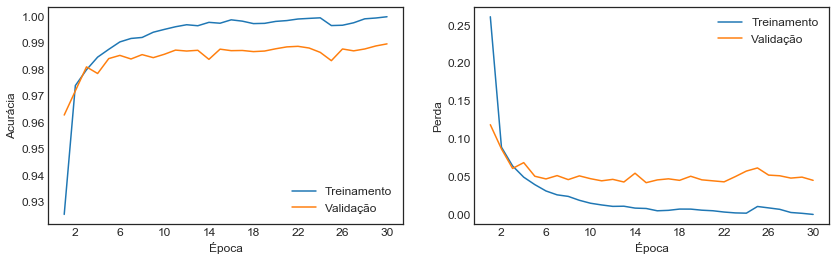

In [37]:
tc_he = TimingCallback()
history_he = model_he.fit(x_train, y_train, epochs=num_epochs, verbose=False, batch_size=batch_size, 
                  validation_data=(x_val, y_val), callbacks=[tc_he])

loss_he, accuracy_he = model_he.evaluate(x_test, y_test, verbose=False)

print("")
print("Acurácia no teste: {:.4f}".format(accuracy_he))
print("Tempo de execução: {:.4f}s".format(tc_he.getTrainTime()))
print("Tempo médio por epóca: {:.4f}s".format(tc_he.getAvgTimePerEpoch()))

visualize_history(history_he, 'LeNet com He')

### 4.17 LeNet com alteração no percentual TVT (Treinamento-Validação-Teste)

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, train_size=0.9, test_size=0.1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.888888, test_size=0.111112)

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

y_train = keras.utils.to_categorical(y_train, 10)
y_val = keras.utils.to_categorical(y_val, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# Extensão por '0'
x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
x_val = np.pad(x_val, ((0,0),(2,2),(2,2),(0,0)), 'constant')
x_test = np.pad(x_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

# Implementação da LeNet Clássica
model_ctt = Sequential()
model_ctt.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(32,32,1)))
model_ctt.add(AveragePooling2D(pool_size=(2, 2)))
model_ctt.add(Conv2D(16, (5, 5), activation='tanh'))
model_ctt.add(AveragePooling2D(pool_size=(2, 2)))

model_ctt.add(Conv2D(120, (5, 5), activation='tanh'))
model_ctt.add(Flatten())
model_ctt.add(Dense(84, activation='tanh'))
model_ctt.add(Dense(10, activation='softmax'))

model_ctt.summary()
model_ctt.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_33 (Averag (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_34 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_18 (Flatten)         (None, 120)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 84)                10164     
__________


Acurácia no teste: 0.9899
Tempo de execução: 1041.8593s
Tempo médio por epóca: 34.7286s


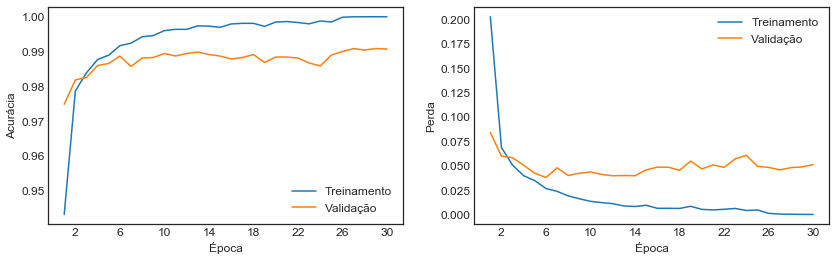

In [40]:
tc_ctt = TimingCallback()
history_ctt = model_ctt.fit(x_train, y_train, epochs=num_epochs, verbose=False, batch_size=batch_size, 
                  validation_data=(x_val, y_val), callbacks=[tc_ctt])

loss_ctt, accuracy_ctt = model_ctt.evaluate(x_test, y_test, verbose=False)

print("")
print("Acurácia no teste: {:.4f}".format(accuracy_ctt))
print("Tempo de execução: {:.4f}s".format(tc_ctt.getTrainTime()))
print("Tempo médio por epóca: {:.4f}s".format(tc_ctt.getAvgTimePerEpoch()))

visualize_history(history_ctt, 'LeNet com alteração no percentual TVT')